<a href="https://colab.research.google.com/github/mchirico/montco911/blob/master/911_Calls_Montco_PA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**911 Calls in Montgomery County PA**

Note:  You need to make a copy of this note book, if you want to run it yourself
by clicking on "File/Save a copy in Drive"



Sharable link:
https://drive.google.com/file/d/1_aZIvr3QWWSbU_DNWEz-E4yDLVR6Emgd/view?usp=sharing








[Google Maps of Accidents](https://storage.googleapis.com/montco-stats/vehicleAccident.html)



In [2]:
import requests
import pandas as pd
import numpy as np 
from datetime import datetime



import warnings
warnings.filterwarnings("ignore")

try:
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive
  import torch
except:
  print("Will try to install software")
  # Lines below .... Only need to be run once at the top of the notebook.
  !pip install -q matplotlib-venn
  !pip install -q keras
  # #   https://pypi.python.org/pypi/pydot
  !apt-get -qq install -y graphviz && pip install -q pydot
  !apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
  !pip install -U -q PyDrive
  !pip install --upgrade -q gspread
  
  !pip install torchvision
  
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive





Using TensorFlow backend.


Will try to install software
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 133872 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.6_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 163kB 7.8MB/s 


In [3]:
def readTZ():
    url="https://storage.googleapis.com/montco-stats/tz.csv"
    d=requests.get(url,verify=True).content
    d=pd.read_csv(url,
                  header=0,names=['lat', 'lng','desc','zip','title','timeStamp','twp','e'],
            dtype={'lat':str,'lng':str,'desc':str,'zip':str,
                  'title':str,'timeStamp':str,'twp':str,'e':int})
    d=pd.DataFrame(d)
    d['timeStamp'] = d['timeStamp'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    return d

d=readTZ()
d.sort_values(by=['timeStamp'], ascending=False, inplace=True)
d.head()





,lat,lng,desc,zip,title,timeStamp,twp,e
625492,40.0806227,-75.1265450,OLD YORK RD & GREEN BRIAR RD; CHELTENHAM; Sta...,19027,EMS: SYNCOPAL EPISODE,2020-03-21 09:57:00,CHELTENHAM,1
625491,40.1320477,-75.3578112,GLEN LN & BEECH ST; WEST NORRITON; Station 30...,19403,EMS: CARDIAC EMERGENCY,2020-03-21 09:52:00,WEST NORRITON,1
625490,40.1546984,-75.1392426,WELSH RD & COMPUTER AVE; UPPER MORELAND; Stat...,19090,EMS: FALL VICTIM,2020-03-21 09:47:00,UPPER MORELAND,1
625489,40.2012016,-75.3465306,SKIPPACK PIKE & VALLEY FORGE RD; WORCESTER; S...,19426,EMS: ALTERED MENTAL STATUS,2020-03-21 09:42:01,WORCESTER,1
625488,40.1457897,-75.1766957,CAMP HILL RD & OFFICE CENTER DR; UPPER DUBLIN...,19034,EMS: UNCONSCIOUS SUBJECT,2020-03-21 09:42:00,UPPER DUBLIN,1


In [4]:
# Use a temp table (t)


t=d[d['timeStamp']>= '2015-01-01']

# Use for easy totals
t['e']=1
p = pd.pivot_table(t, values='e', index=['timeStamp'], columns=['title'], aggfunc=np.sum)


# 1 hour intervals
pp = p.resample('1h').apply(np.sum).reset_index()


pp.columns = pp.columns.get_level_values(0)

pp.fillna(0, inplace=True)
pp.sort_values(by=['timeStamp'], ascending=False, inplace=True)
pp[['timeStamp','Traffic: VEHICLE ACCIDENT -','Traffic: DISABLED VEHICLE -','Traffic: HAZARDOUS ROAD CONDITIONS -','EMS: VEHICLE ACCIDENT']].head(9)


title,timeStamp,Traffic: VEHICLE ACCIDENT -,Traffic: DISABLED VEHICLE -,Traffic: HAZARDOUS ROAD CONDITIONS -,EMS: VEHICLE ACCIDENT
37504,2020-03-21 09:00:00,0.0,0.0,0.0,0.0
37503,2020-03-21 08:00:00,2.0,0.0,0.0,1.0
37502,2020-03-21 07:00:00,1.0,3.0,0.0,1.0
37501,2020-03-21 06:00:00,1.0,0.0,0.0,0.0
37500,2020-03-21 05:00:00,0.0,0.0,0.0,0.0
37499,2020-03-21 04:00:00,2.0,0.0,0.0,1.0
37498,2020-03-21 03:00:00,0.0,0.0,0.0,0.0
37497,2020-03-21 02:00:00,0.0,0.0,0.0,0.0
37496,2020-03-21 01:00:00,1.0,0.0,0.0,0.0


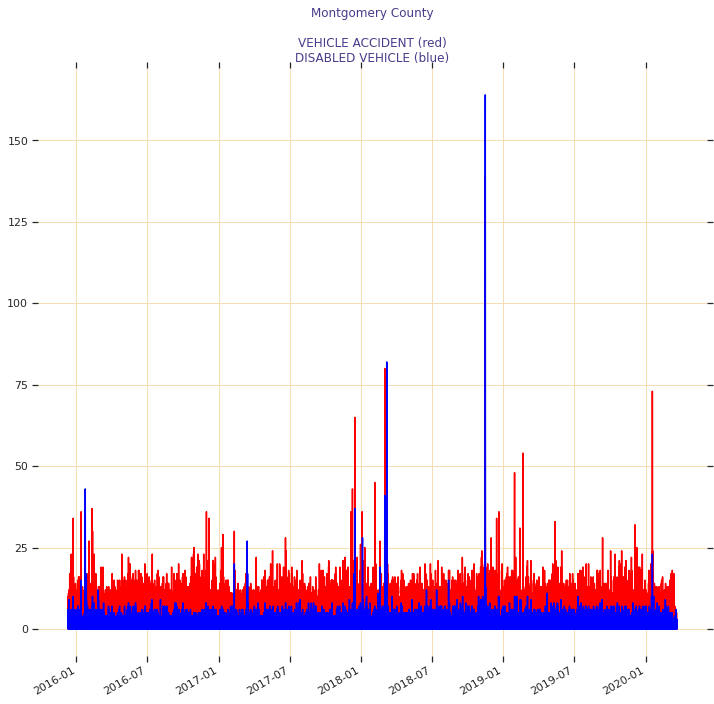

In [5]:


t=pp[pp['timeStamp']>= '2015-03-02']
#t=pp[pp['timeStamp']>= '2020-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12,12))



ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['Traffic: DISABLED VEHICLE -'],color = 'blue')

ax.set_title("Montgomery County\n\nVEHICLE ACCIDENT (red)\nDISABLED VEHICLE (blue)", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

## EMS Calls

In [6]:
#d.head()
#d[d['title'].str.contains('RESPIRATORY', na=False)]

# Use a temp table (t)


t=d[d['timeStamp']>= '2015-01-01']

# Use for easy totals
t['e']=1
p = pd.pivot_table(t, values='e', index=['timeStamp'], columns=['title'], aggfunc=np.sum)


# h 1 hour intervals
# d 1 day 
pp = p.resample('3d').apply(np.sum).reset_index()


pp.columns = pp.columns.get_level_values(0)

pp.fillna(0, inplace=True)
pp.sort_values(by=['timeStamp'], ascending=False, inplace=True)
pp[['timeStamp','EMS: FEVER']].head(9)


title,timeStamp,EMS: FEVER
521,2020-03-21,4.0
520,2020-03-18,15.0
519,2020-03-15,13.0
518,2020-03-12,22.0
517,2020-03-09,16.0
516,2020-03-06,15.0
515,2020-03-03,7.0
514,2020-02-29,7.0
513,2020-02-26,8.0


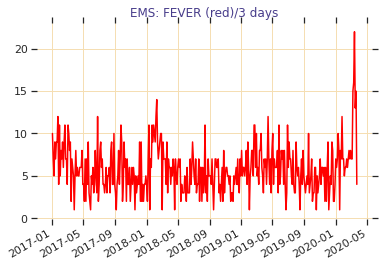

In [7]:
t=pp[pp['timeStamp']>= '2017-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


#ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['EMS: FEVER'],color = 'red')

ax.set_title("EMS: FEVER (red)/3 days", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

In [8]:
pp[(pp['timeStamp']>= '2020-01-02')][['EMS: FEVER','timeStamp']]


title,EMS: FEVER,timeStamp
521,4.0,2020-03-21
520,15.0,2020-03-18
519,13.0,2020-03-15
518,22.0,2020-03-12
517,16.0,2020-03-09
516,15.0,2020-03-06
515,7.0,2020-03-03
514,7.0,2020-02-29
513,8.0,2020-02-26
512,7.0,2020-02-23


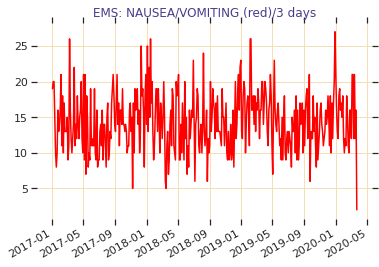

In [9]:
t=pp[pp['timeStamp']>= '2017-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


#ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['EMS: NAUSEA/VOMITING'],color = 'red')

ax.set_title("EMS: NAUSEA/VOMITING (red)/3 days", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

# Playground... ideas


In [26]:
t=d[d['timeStamp']>= '2015-01-01']

# Use for easy totals
t['e']=1
p2 = pd.pivot_table(t, values='e', index=['timeStamp','twp'], columns=['title'], aggfunc=np.sum)




p2 = p2.reset_index()

pp2 = p2.groupby(['twp', pd.Grouper(key='timeStamp', freq='5d')])['EMS: FEVER','EMS: NAUSEA/VOMITING'].sum()
pp2=pp2.reset_index()
pp2.head()

title,twp,timeStamp,EMS: FEVER,EMS: NAUSEA/VOMITING
0,ABINGTON,2015-12-10,1.0,0.0
1,ABINGTON,2015-12-15,1.0,0.0
2,ABINGTON,2015-12-20,0.0,2.0
3,ABINGTON,2015-12-25,1.0,4.0
4,ABINGTON,2015-12-30,0.0,0.0


In [27]:

pp2[(pp2['timeStamp']>= '2020-03-10') & (pp2['EMS: FEVER'] > 1)]

title,twp,timeStamp,EMS: FEVER,EMS: NAUSEA/VOMITING
2176,CHELTENHAM,2020-03-13,2.0,2.0
2490,CHESTER COUNTY,2020-03-18,2.0,0.0
6090,HORSHAM,2020-03-13,2.0,0.0
8088,LOWER MERION,2020-03-18,3.0,0.0
8713,LOWER POTTSGROVE,2020-03-13,2.0,0.0
10901,NORRISTOWN,2020-03-13,3.0,2.0
10902,NORRISTOWN,2020-03-18,2.0,4.0
15090,SPRINGFIELD,2020-03-13,3.0,0.0
16332,UPPER DUBLIN,2020-03-18,2.0,0.0
17897,UPPER MORELAND,2020-03-18,2.0,0.0


In [38]:
z=pp2[(pp2['timeStamp']>= '2020-02-01') & (pp2['EMS: FEVER'] > 1)]
z.head()

title,twp,timeStamp,EMS: FEVER,EMS: NAUSEA/VOMITING
303,ABINGTON,2020-02-02,2.0,1.0
310,ABINGTON,2020-03-08,3.0,3.0
623,AMBLER,2020-03-08,3.0,0.0
2172,CHELTENHAM,2020-02-22,2.0,1.0
2176,CHELTENHAM,2020-03-13,2.0,2.0


In [51]:

zz=pd.pivot_table(z, values='EMS: FEVER', index=['timeStamp'], columns=['twp'], aggfunc=np.sum)
tz=zz.sort_index(axis=0, level=None, ascending=False).fillna(0)
tz=tz.reset_index()

tz['Total']=tz.sum(numeric_only=True, axis=1)
tz


twp,timeStamp,ABINGTON,AMBLER,CHELTENHAM,CHESTER COUNTY,HORSHAM,LOWER MERION,LOWER MORELAND,LOWER POTTSGROVE,LOWER PROVIDENCE,NORRISTOWN,POTTSTOWN,SPRINGFIELD,UPPER DUBLIN,UPPER MORELAND,Total
0,2020-03-18,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,11.0
1,2020-03-13,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,3.0,0.0,0.0,12.0
2,2020-03-08,3.0,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,12.0
3,2020-03-03,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0
4,2020-02-27,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0
5,2020-02-22,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0
6,2020-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0
7,2020-02-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
8,2020-02-07,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,8.0
9,2020-02-02,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [12]:

t['twp'].value_counts()

LOWER MERION       52628
ABINGTON           37598
NORRISTOWN         34957
UPPER MERION       34248
CHELTENHAM         28806
                   ...  
EAST GREENVILLE     1249
BRYN ATHYN          1180
GREEN LANE           377
PHILA COUNTY         252
LEHIGH COUNTY        182
Name: twp, Length: 68, dtype: int64

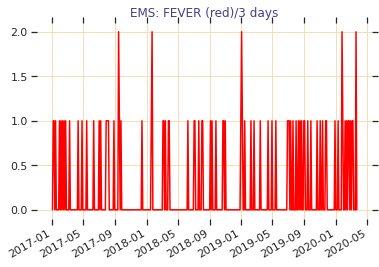

In [13]:
t=pp2[pp2['timeStamp']>= '2017-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


r=t[t['twp']=='UPPER MORELAND']
ax.plot(r['timeStamp'],r['EMS: FEVER'],color = 'red')

ax.set_title("EMS: FEVER (red)/3 days", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

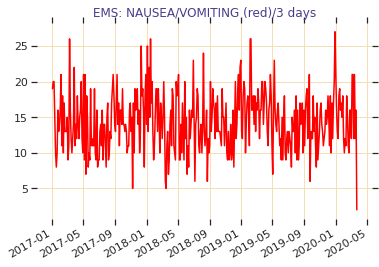

In [14]:
t=pp[pp['timeStamp']>= '2017-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


#ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['EMS: NAUSEA/VOMITING'],color = 'red')

ax.set_title("EMS: NAUSEA/VOMITING (red)/3 days", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

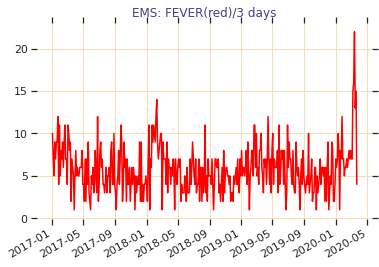

In [15]:
t=pp[pp['timeStamp']>= '2017-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


#ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['EMS: FEVER'],color = 'red')

ax.set_title("EMS: FEVER(red)/3 days", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

In [16]:
# Use a temp table (t)


t=d[d['timeStamp']>= '2015-01-01']

# Use for easy totals
t['e']=1
p = pd.pivot_table(t, values='e', index=['timeStamp'], columns=['title'], aggfunc=np.sum)


# 1 hour intervals
pp = p.resample('1h').apply(np.sum).reset_index()


pp.columns = pp.columns.get_level_values(0)

pp.fillna(0, inplace=True)
pp.sort_values(by=['timeStamp'], ascending=False, inplace=True)
pp[['timeStamp','Traffic: VEHICLE ACCIDENT -','Traffic: DISABLED VEHICLE -','Traffic: HAZARDOUS ROAD CONDITIONS -','EMS: VEHICLE ACCIDENT']].head(9)


title,timeStamp,Traffic: VEHICLE ACCIDENT -,Traffic: DISABLED VEHICLE -,Traffic: HAZARDOUS ROAD CONDITIONS -,EMS: VEHICLE ACCIDENT
37504,2020-03-21 09:00:00,0.0,0.0,0.0,0.0
37503,2020-03-21 08:00:00,2.0,0.0,0.0,1.0
37502,2020-03-21 07:00:00,1.0,3.0,0.0,1.0
37501,2020-03-21 06:00:00,1.0,0.0,0.0,0.0
37500,2020-03-21 05:00:00,0.0,0.0,0.0,0.0
37499,2020-03-21 04:00:00,2.0,0.0,0.0,1.0
37498,2020-03-21 03:00:00,0.0,0.0,0.0,0.0
37497,2020-03-21 02:00:00,0.0,0.0,0.0,0.0
37496,2020-03-21 01:00:00,1.0,0.0,0.0,0.0



**CARDIAC ARREST**


In [17]:
# Use a temp table (t)


t=d[d['timeStamp']>= '2015-01-01']

# Use for easy totals
t['e']=1
p = pd.pivot_table(t, values='e', index=['timeStamp'], columns=['title'], aggfunc=np.sum)


# 1 hour intervals
pp = p.resample('6h').apply(np.sum).reset_index()


pp.columns = pp.columns.get_level_values(0)

pp.fillna(0, inplace=True)
pp.sort_values(by=['timeStamp'], ascending=False, inplace=True)
pp[['timeStamp','EMS: CARDIAC ARREST','EMS: FALL VICTIM','Traffic: VEHICLE ACCIDENT -','EMS: VEHICLE ACCIDENT']].head(10)


title,timeStamp,EMS: CARDIAC ARREST,EMS: FALL VICTIM,Traffic: VEHICLE ACCIDENT -,EMS: VEHICLE ACCIDENT
6251,2020-03-21 06:00:00,2.0,1.0,4.0,2.0
6250,2020-03-21 00:00:00,1.0,1.0,5.0,1.0
6249,2020-03-20 18:00:00,2.0,5.0,6.0,1.0
6248,2020-03-20 12:00:00,2.0,6.0,12.0,1.0
6247,2020-03-20 06:00:00,1.0,5.0,10.0,2.0
6246,2020-03-20 00:00:00,0.0,2.0,0.0,0.0
6245,2020-03-19 18:00:00,0.0,4.0,5.0,1.0
6244,2020-03-19 12:00:00,1.0,2.0,15.0,0.0
6243,2020-03-19 06:00:00,1.0,6.0,11.0,2.0
6242,2020-03-19 00:00:00,0.0,5.0,2.0,0.0


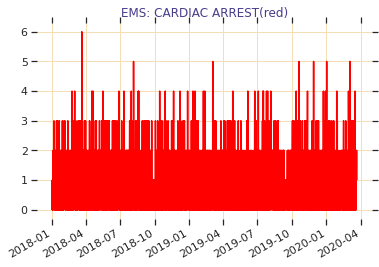

In [18]:
t=pp[pp['timeStamp']>= '2018-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


#ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['EMS: CARDIAC ARREST'],color = 'red')

ax.set_title("EMS: CARDIAC ARREST(red)", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

In [0]:
# Ref: 'https://insights.arcgis.com/index.html#/embed/0b41be4066764191a8a99ad6f377a365'
